# **Galaxy Classification**

Galaxy Classification with Python/R, colab.

Data: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data


The Galaxy Zoo 2 decision tree: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview/the-galaxy-zoo-decision-tree

**Data Description**

1. images_training: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

2. solutions_training: Probability distributions for the classifications for each of the training images.

3. images_test: JPG images of 79975 galaxies. Files are name according to their GalaxyId. You will provide probabilities for each of these images. 

4. all_ones_benchmark: Sample submission file corresponding to the All Ones Benchmark

5. all_zeros_benchmark: Sample submission file corresponding to the All Zeros Benchmark

6. central_pixel_benchmark: Simple benchmark that clusters training galaxies according to the color in the center of the image and then assigns the associated probability values to like-colored images in the test set.

The first column in each solution is labeled GalaxyID; this is a randomly-generated ID that only allows you to match the probability distributions with the images.

The next 37 columns are all floating point numbers between 0 and 1 inclusive. These represent the morphology (or shape) of the galaxy in 37 different categories as identified by crowdsourced volunteer classifications as part of the Galaxy Zoo 2 project. These morphologies are related to probabilities for each category; a high number (close to 1) indicates that many users identified this morphology category for the galaxy with a high level of confidence. Low numbers for a category (close to 0) indicate the feature is likely not present. 

# Import Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import random
import shutil
import itertools
import glob
import string
import pickle
import json
import re

from bson import json_util

import numpy as np
import pandas as pd

from tqdm import tqdm
from time import time
from PIL import Image
from datetime import date
from keras.preprocessing import image


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [ ]:
print(tf.__version__)
tf.test.gpu_device_name()

2.6.0


'/device:GPU:0'

In [ ]:
# from urllib.request import urlopen
# from io import BytesIO
# from zipfile import ZipFile

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Fri Oct 15 13:17:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    72W / 149W |    121MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


**Project "Galaxy Classifier" directory in google drive:**

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/galaxy_classifier/
!ls

**Data for "Galaxy Classifier" directory in google drive:**

In [ ]:
%cd /content/gdrive/My Drive/data/galaxy_data/
!ls

# Data path

In [ ]:
current_dir = os.getcwd()
print(current_dir)

data_path    = '/content/gdrive/My Drive/data/galaxy_data'
training_dir = os.path.join(data_path, 'training')
valid_dir    = os.path.join(data_path, 'validation')

/content/gdrive/My Drive/data/galaxy_data


In [ ]:
# Check the total number of training and validation samples:
data_dir = data_path
n_round_train           = len(os.listdir(os.path.join(data_dir, 'training', '0_completely_round_smooth')))
n_inbetween_train       = len(os.listdir(os.path.join(data_dir, 'training', '1_in_between_smooth')))
n_cigar_train           = len(os.listdir(os.path.join(data_dir, 'training', '2_cigar_shaped_smooth')))
n_lenticular_train      = len(os.listdir(os.path.join(data_dir, 'training', '3_lenticulars')))
n_barred_spriral_train  = len(os.listdir(os.path.join(data_dir, 'training', '4_barred_spirals')))
n_unbarred_spiral_train = len(os.listdir(os.path.join(data_dir, 'training', '5_unbarred_spirals')))
n_irregular_train       = len(os.listdir(os.path.join(data_dir, 'training', '6_irregular')))
print('Total train 0_completely_round_smooth:', n_round_train)
print('Total train 1_in_between_smooth:', n_inbetween_train)
print('Total train 2_cigar_shaped_smooth:', n_cigar_train)
print('Total train 3_lenticulars:', n_lenticular_train)
print('Total train 4_barred_spirals:', n_barred_spriral_train)
print('Total train 5_unbarred_spirals:', n_unbarred_spiral_train)
print('Total train 6_irregular:', n_irregular_train)

print()
print()
n_round_valid           = len(os.listdir(os.path.join(data_dir, 'validation', '0_completely_round_smooth')))
n_inbetween_valid       = len(os.listdir(os.path.join(data_dir, 'validation', '1_in_between_smooth')))
n_cigar_valid           = len(os.listdir(os.path.join(data_dir, 'validation', '2_cigar_shaped_smooth')))
n_lenticular_valid      = len(os.listdir(os.path.join(data_dir, 'validation', '3_lenticulars')))
n_barred_spriral_valid  = len(os.listdir(os.path.join(data_dir, 'validation', '4_barred_spirals')))
n_unbarred_spiral_valid = len(os.listdir(os.path.join(data_dir, 'validation', '5_unbarred_spirals')))
n_irregular_valid       = len(os.listdir(os.path.join(data_dir, 'validation', '6_irregular')))
print('Total validation 0_completely_round_smooth:', n_round_valid)
print('Total validation 1_in_between_smooth:', n_inbetween_valid)
print('Total validation 2_cigar_shaped_smooth:', n_cigar_valid)
print('Total validation 3_lenticulars:', n_lenticular_valid)
print('Total validation 4_barred_spirals:', n_barred_spriral_valid)
print('Total validation 5_unbarred_spirals:', n_unbarred_spiral_valid)
print('Total validation 6_irregular:', n_irregular_valid)

Total train 0_completely_round_smooth: 5946
Total train 1_in_between_smooth: 5718
Total train 2_cigar_shaped_smooth: 430
Total train 3_lenticulars: 2787
Total train 4_barred_spirals: 620
Total train 5_unbarred_spirals: 2525
Total train 6_irregular: 1176


Total validation 0_completely_round_smooth: 1983
Total validation 1_in_between_smooth: 1906
Total validation 2_cigar_shaped_smooth: 144
Total validation 3_lenticulars: 929
Total validation 4_barred_spirals: 207
Total validation 5_unbarred_spirals: 842
Total validation 6_irregular: 392


In [ ]:
classes = ['2_cigar_shaped_smooth',
 '4_barred_spirals',
 '6_irregular',
 '5_unbarred_spirals',
 '3_lenticulars',
 '1_in_between_smooth',
 '0_completely_round_smooth']

In [ ]:
# Get the total images in the training and validation dataset, this should be around 8619 images for training, and 2875 for validation.
total_train = 0
for c in classes:
  total_train += len(os.listdir(os.path.join(training_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in classes:
  total_validation += len(os.listdir(os.path.join(valid_dir, c)))
print('Total validation:', total_validation)

Total train: 19202
Total validation: 6403


# Data Augmentation

In [ ]:
dir_augmented_data = os.path.join(data_path, 'preview')
try:
    ## if the preview folder does not exist, create
    os.mkdir(dir_augmented_data)
except:
    ## if the preview folder exists, then remove
    ## the contents (pictures) in the folder
    for item in os.listdir(dir_augmented_data):
        os.remove(dir_augmented_data + "/" + item)


# Resize the images to (x, x) pixels
target_size = (150, 150)

# Set the batch size.
batch_size = 32

# Color channels
color_channels = 3


# Create the data generator for both sets, but now with image augmentation,
# where random operations are made on images like random shifts or rotationson each batch,
# stil do the rescale and set the target size.

# datagen for training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale            = 1./255.,
                    rotation_range     = 25,
                    width_shift_range  = 0.15,
                    height_shift_range = 0.15,
                    horizontal_flip    = True,
                    zoom_range         = 0.2)


train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size = target_size,
                                                    batch_size  = batch_size,
                                                    shuffle     = True,
                                                    class_mode  = 'categorical')


# datagen for validation set
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                         target_size = target_size,
                                                         batch_size  = batch_size,
                                                         shuffle     = False,
                                                         class_mode  = 'categorical')

allclasses = train_generator.class_indices    
print('ALL classes:')
print(allclasses)

Found 19202 images belonging to 7 classes.
Found 6403 images belonging to 7 classes.
ALL classes:
{'0_completely_round_smooth': 0, '1_in_between_smooth': 1, '2_cigar_shaped_smooth': 2, '3_lenticulars': 3, '4_barred_spirals': 4, '5_unbarred_spirals': 5, '6_irregular': 6}


In [ ]:
# To see what's going on this data augmentation, run the following
if False:
  i = 0
  for batch in train_datagen.flow_from_directory(training_dir,
      target_size = target_size, batch_size  = batch_size,
      save_to_dir = dir_augmented_data, save_prefix = 'pic', save_format = 'png',
      color_mode = 'grayscale', shuffle = True, class_mode  = 'categorical'):

      i += 1
      if i > 5: # save 20 images
          break  # otherwise the generator would loop indefinitely

# Class Weights

In [ ]:
# Class names and number of images
classes = {
    "names" : ['completely round smooth', 'in between smooth', 'cigar shaped smooth', 'lenticulars', 'barred spirals', 'unbarred spirals', 'irregular'],
    "length" : [7929, 7624, 574, 3716, 827, 3367, 1568]
}

In [ ]:
# To dataframe
class_df = pd.DataFrame(classes)
class_df.index.tolist()

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
class_df = class_df.sort_values(by="length", ascending=True)

In [ ]:
class_df

,names,length
2,cigar shaped smooth,574
4,barred spirals,827
6,irregular,1568
5,unbarred spirals,3367
3,lenticulars,3716
1,in between smooth,7624
0,completely round smooth,7929


In [ ]:
print(class_df['length'].sum())
print(class_df.index)
# print(label_freq_df.values)
print(class_df.loc[1])

25605
Int64Index([2, 4, 6, 5, 3, 1, 0], dtype='int64')
names     in between smooth
length                 7624
Name: 1, dtype: object


Some labels occur more often than others, thus the classes are not well balanced. The imbalanced class problem can be addressed by applying class weights, thus weighting less frequent labels higher than very frequent labels.

In [ ]:
class_df['class_weight'] = (class_df['length'].max() / class_df['length'])**1.4
class_df

,names,length,class_weight
2,cigar shaped smooth,574,39.484727
4,barred spirals,827,23.680893
6,irregular,1568,9.669885
5,unbarred spirals,3367,3.317152
3,lenticulars,3716,2.889348
1,in between smooth,7624,1.056452
0,completely round smooth,7929,1.000000


In [ ]:
class_weight = {}
for index, label in enumerate(class_df['names']):
    class_weight[index] = class_df.loc[index]['class_weight']

class_weight

{0: 1.0,
 1: 1.0564519335549225,
 2: 39.48472663777914,
 3: 2.8893476346098566,
 4: 23.680892789116538,
 5: 3.317152379152498,
 6: 9.669884868134252}

# **The model**

In [ ]:
# Create the model, using a sequence of convolution and pooling layers,
# followed by a dropout layer, a fully connected layer, and the last softmax layer.

# Xem: https://forum.machinelearningcoban.com/t/tutorial-tinh-so-luong-parameters-trong-convolutional-neural-network/3638


model = tf.keras.models.Sequential([
    # first convolution layer, input is an 64x64 image x3 colors
    # 64 filters, with a size of (3x3) for each filter (each filter has 3x3 = 9 weights)
    # e.g: input = 28x28 pixels
    #      kernel filter = (3,3)
    #      No. of filters: 32
    #     -> Output of Conv2D layer: (28 x 28 x 32)
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           input_shape=(target_size[0],target_size[1], color_channels)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()  # inspect model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
# Compile the model to use a categorical cross entropy loss function, and a adam optmizier.
from tensorflow.keras import losses
loss_fcn = tf.keras.losses.CategoricalCrossentropy(from_logits=False,
                                              label_smoothing=0,
                                              reduction="auto",
                                              name="categorical_crossentropy"
                                            )
model.compile(loss=loss_fcn,
              optimizer='adam',
              metrics=['accuracy'])

# **Train the model**

In [ ]:
# Use callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                              mode = 'max',
                                              patience=10,
                                              restore_best_weights=False
                                            )

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 patience=5,
                                                 min_lr=0.001
                                                )

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
EPOCHS = 100

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    class_weight=class_weight,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator)//batch_size,
                    callbacks=[early_stop, reduce_lr], # use callbacks
                    verbose=True)

Epoch 1/100
600/600 [==============================] - 12895s 21s/step - loss: 6.9508 - accuracy: 0.0432 - val_loss: 2.4151 - val_accuracy: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 195s 324ms/step - loss: 6.2382 - accuracy: 0.1186 - val_loss: 2.0012 - val_accuracy: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 195s 325ms/step - loss: 5.3950 - accuracy: 0.1863 - val_loss: 1.5938 - val_accuracy: 0.2656
Epoch 4/100
600/600 [==============================] - 195s 325ms/step - loss: 4.8714 - accuracy: 0.2690 - val_loss: 1.1560 - val_accuracy: 0.7083
Epoch 5/100
600/600 [==============================] - 194s 324ms/step - loss: 4.5764 - accuracy: 0.3225 - val_loss: 1.6406 - val_accuracy: 0.4323
Epoch 6/100
600/600 [==============================] - 194s 323ms/step - loss: 4.3472 - accuracy: 0.3731 - val_loss: 1.8500 - val_accuracy: 0.3906
Epoch 7/100
600/600 [==============================] - 193s 321ms/step - loss: 4.1171 - accuracy: 0.4065 - val

In [ ]:
print(data_path + '/train_hist_dict_07classes_classweight.pkl')
with open(data_path + '/train_hist_dict_07classes_classweight.pkl', 'wb') as file_hist:
        pickle.dump(history.history, file_hist)

/content/gdrive/My Drive/data/galaxy_data/train_hist_dict_07classes_classweight.pkl


**Finish training -> plot graphs**

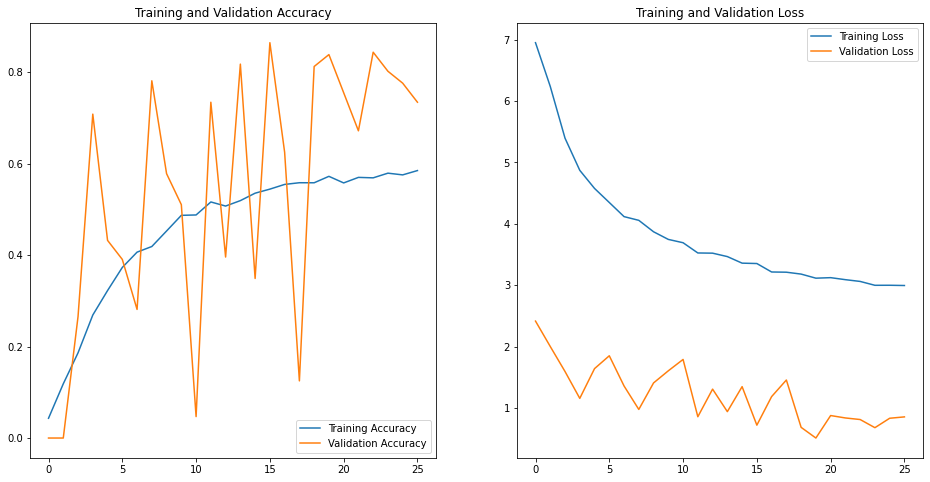

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(data_path + '/plots.png')
plt.show()

# **Prediction**

In [ ]:
def _load_image(img_path, show=False):

    img = image.load_img(img_path, target_size = target_size)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
inv_classes = {v: k for k, v in allclasses.items()}
inv_classes

{0: '0_completely_round_smooth',
 1: '1_in_between_smooth',
 2: '2_cigar_shaped_smooth',
 3: '3_lenticulars',
 4: '4_barred_spirals',
 5: '5_unbarred_spirals',
 6: '6_irregular'}

## Image 1

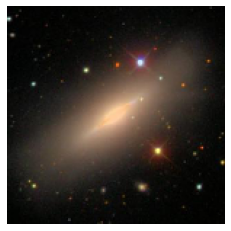

All classes:  {'0_completely_round_smooth': 0, '1_in_between_smooth': 1, '2_cigar_shaped_smooth': 2, '3_lenticulars': 3, '4_barred_spirals': 4, '5_unbarred_spirals': 5, '6_irregular': 6}
Prediction: 
Class predictions with probabilities:  [0.02517651 0.03817713 0.02067769 0.15332197 0.03249824 0.02024425
 0.70990425]
Predicted class-ID:  6
Predited class:  6_irregular


In [ ]:
# Load image
img_path  = data_path + '/test/lenticular-galaxy-eg3.jpg'

ximg_pred = _load_image(img_path, show=True)

# check prediction
pred = model.predict(ximg_pred)

# Generate arg maxes for predictions
print('All classes: ', allclasses)
print('Prediction: ')
print('Class predictions with probabilities: ', *pred)
classes = np.argmax(pred, axis = 1)
print('Predicted class-ID: ', *classes)
print('Predited class: ', inv_classes[ classes[0] ] )

## Image 2

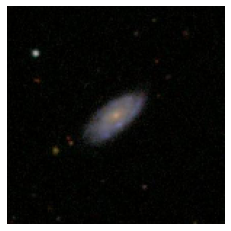

All classes:  {'0_completely_round_smooth': 0, '1_in_between_smooth': 1, '2_cigar_shaped_smooth': 2, '3_lenticulars': 3, '4_barred_spirals': 4, '5_unbarred_spirals': 5, '6_irregular': 6}
Prediction: 
Class predictions with probabilities:  [4.2479174e-04 2.4252969e-03 3.5544435e-04 5.0263770e-05 7.9102032e-02
 8.1030345e-01 1.0733881e-01]
Predicted class-ID:  5
Predited class:  5_unbarred_spirals


In [ ]:
# Load image
img_path  = data_path + '/test/spiral-1.jpg'

ximg_pred = _load_image(img_path, show=True)

# check prediction
pred = model.predict(ximg_pred)

# Generate arg maxes for predictions
print('All classes: ', allclasses)
print('Prediction: ')
print('Class predictions with probabilities: ', *pred)
classes = np.argmax(pred, axis = 1)
print('Predicted class-ID: ', *classes)
print('Predited class: ', inv_classes[ classes[0] ] )

## Image 3

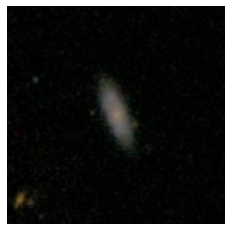

All classes:  {'0_completely_round_smooth': 0, '1_in_between_smooth': 1, '2_cigar_shaped_smooth': 2, '3_lenticulars': 3, '4_barred_spirals': 4, '5_unbarred_spirals': 5, '6_irregular': 6}
Prediction: 
Class predictions with probabilities:  [1.9580049e-04 1.5557187e-02 6.9135565e-01 3.3543874e-02 1.6409669e-02
 1.6295110e-01 7.9986714e-02]
Predicted class-ID:  2
Predited class:  2_cigar_shaped_smooth


In [ ]:
# Load image
img_path  = data_path + '/test/cigar-1.jpg'

ximg_pred = _load_image(img_path, show=True)

# check prediction
pred = model.predict(ximg_pred)

# Generate arg maxes for predictions
print('All classes: ', allclasses)
print('Prediction: ')
print('Class predictions with probabilities: ', *pred)
classes = np.argmax(pred, axis = 1)
print('Predicted class-ID: ', *classes)
print('Predited class: ', inv_classes[ classes[0] ] )

## Image 4

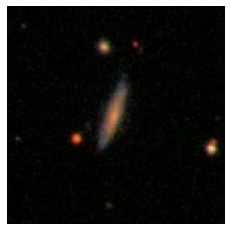

All classes:  {'0_completely_round_smooth': 0, '1_in_between_smooth': 1, '2_cigar_shaped_smooth': 2, '3_lenticulars': 3, '4_barred_spirals': 4, '5_unbarred_spirals': 5, '6_irregular': 6}
Prediction: 
Class predictions with probabilities:  [8.4125261e-08 1.5320884e-05 1.2028190e-01 8.6345047e-01 1.4970022e-04
 2.6415914e-04 1.5838267e-02]
Predicted class-ID:  3
Predited class:  3_lenticulars


In [ ]:
# Load image
img_path  = data_path + '/test/lenticular-1.jpg'

ximg_pred = _load_image(img_path, show=True)

# check prediction
pred = model.predict(ximg_pred)

# Generate arg maxes for predictions
print('All classes: ', allclasses)
print('Prediction: ')
print('Class predictions with probabilities: ', *pred)
classes = np.argmax(pred, axis = 1)
print('Predicted class-ID: ', *classes)
print('Predited class: ', inv_classes[ classes[0] ] )

## Image 5

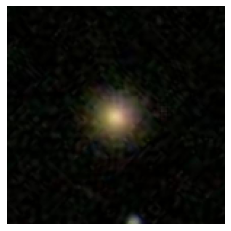

All classes:  {'0_completely_round_smooth': 0, '1_in_between_smooth': 1, '2_cigar_shaped_smooth': 2, '3_lenticulars': 3, '4_barred_spirals': 4, '5_unbarred_spirals': 5, '6_irregular': 6}
Prediction: 
Class predictions with probabilities:  [6.4783192e-01 3.2504514e-01 1.1891227e-04 2.2261958e-05 1.3299659e-04
 6.0512236e-04 2.6243560e-02]
Predicted class-ID:  0
Predited class:  0_completely_round_smooth


In [ ]:
# Load image
img_path  = data_path + '/test/round-1.jpg'

ximg_pred = _load_image(img_path, show=True)

# check prediction
pred = model.predict(ximg_pred)

# Generate arg maxes for predictions
print('All classes: ', allclasses)
print('Prediction: ')
print('Class predictions with probabilities: ', *pred)
classes = np.argmax(pred, axis = 1)
print('Predicted class-ID: ', *classes)
print('Predited class: ', inv_classes[ classes[0] ] )

## Image 6

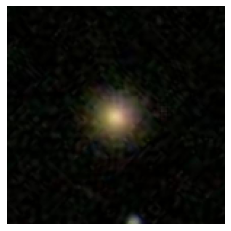

All classes:  {'0_completely_round_smooth': 0, '1_in_between_smooth': 1, '2_cigar_shaped_smooth': 2, '3_lenticulars': 3, '4_barred_spirals': 4, '5_unbarred_spirals': 5, '6_irregular': 6}
Prediction: 
Class predictions with probabilities:  [6.4783192e-01 3.2504514e-01 1.1891227e-04 2.2261958e-05 1.3299659e-04
 6.0512236e-04 2.6243560e-02]
Predicted class-ID:  0
Predited class:  0_completely_round_smooth


In [ ]:
# Load image
img_path  = data_path + '/test/round-1.jpg'

ximg_pred = _load_image(img_path, show=True)

# check prediction
pred = model.predict(ximg_pred)

# Generate arg maxes for predictions
print('All classes: ', allclasses)
print('Prediction: ')
print('Class predictions with probabilities: ', *pred)
classes = np.argmax(pred, axis = 1)
print('Predicted class-ID: ', *classes)
print('Predited class: ', inv_classes[ classes[0] ] )

# **Save the trained model**

In [ ]:
model.save(data_path + '/galaxy_convnet_rgb_07classes_classweight.h5')

# Conclusion



1.   Trained a simple CNN model to classify 07 types of galaxies, taking class weights into consideration to deal with imbalanced dataset.
2.   Saved the train model.
3. Prediction on new images using the trained model.
4. Next, I'll use InceptionV3 pre-trained structure to classify the galaxies.



